# The effictiviness of measures to combat cellphone robery in the City of São Paulo

In [1]:
import pandas as pd
import polars as pl
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Importing the data

In [2]:
stolen_cellphones_df = pd.read_pickle("Stollen_cell.pkl")

## Data treatment

- Using the data description as support we can beging to filter ours columns. First we will identify the columns where we have less than half of non-NaN values, those will not be used, this could happend because of a change in the metodology in the collection of the report.
- We will also be droping where the columns about where the BO was registred, since the police that collected the BO is not responsible for investigating, only the precinct of the area that the crime happened. 
- We can also filter some variable that are identical in all of the observations. Like in the variable `DESCR_MODO_OBJETO`, where all the observation say that the object was stollen. The same thing happens in `DESCR_TIPO_OBJETO`,`DESCR_SUBTIPO_OBJETO`.
- Then we can filter all other observations that are not from São Paulo
- We can join the columns `DATA_OCORRENCIA_BO` and `HORA_OCORRENCIA` to get the precise time at which the crime happened, that also means we can drop the `MES` and `ANO` columns.

In [3]:
navalue_count = stolen_cellphones_df.notna().sum()
columns_to_drop = list(navalue_count[navalue_count < stolen_cellphones_df.shape[0]/2].index)
columns_to_drop

['TIPO_INTOLERANCIA',
 'DESDOBRAMENTO',
 'CIRCUNSTANCIA',
 'VERSAO',
 'FLAG_ATO_INFRACIONAL',
 'LOGRADOURO_VERSAO',
 'FLAG_BLOQUEIO',
 'FLAG_DESBLOQUEIO']

In [4]:
columns_BO_register = ['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 
                       'NOME_DELEGACIA', 'NOME_MUNICIPIO', 'ANO_BO', 'NUM_BO', 
                       'DATAHORA_REGISTRO_BO', 'DATA_COMUNICACAO_BO', 'DATAHORA_IMPRESSAO_BO']
columns_redundant = ['DESCR_MODO_OBJETO', 'DESCR_TIPO_OBJETO', 'DESCR_SUBTIPO_OBJETO']
columns_to_drop += columns_BO_register + columns_redundant

In [5]:
stolen_cellphones_filtered = stolen_cellphones_df.drop(columns_to_drop, axis=1)
stolen_cellphones_filtered["CIDADE"] = stolen_cellphones_filtered["CIDADE"].str.strip().str.lower()
stolen_cellphones_filtered["BAIRRO"] = stolen_cellphones_filtered["BAIRRO"].str.strip().str.lower()
stolen_cellphones_filtered = stolen_cellphones_filtered[stolen_cellphones_filtered["CIDADE"] == "s.paulo"] 


In [6]:
#stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']]
import re
tmp = []
for _, date in stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']].iterrows():
    try:
        date_str = re.search(r'\d{4}-\d{2}-\d{2}', str(date['DATA_OCORRENCIA_BO'])).group()
    except AttributeError:
        tmp.append("9999-99-99")
        continue
    try:
        hour = re.search(r'\d{2}:\d{2}:\d{2}', str(date['HORA_OCORRENCIA'])).group()
        tmp.append(date_str + ' ' + hour)
    except:
        tmp.append(date_str + ' ' + '00:00:00')
        continue

In [7]:
stolen_cellphones_filtered['DATA_OCORRENCIA'] = tmp
stolen_cellphones_filtered = stolen_cellphones_filtered[(stolen_cellphones_filtered['DATA_OCORRENCIA'] >= "2017") & (stolen_cellphones_filtered['DATA_OCORRENCIA'] < "2024")]
stolen_cellphones_filtered['DATA_OCORRENCIA'] = pd.to_datetime(stolen_cellphones_filtered['DATA_OCORRENCIA'], format="%Y-%m-%d %H:%M:%S", errors="coerce")
stolen_cellphones_filtered.reset_index(inplace=True)

## EDA (Exploratory Data Analysis)

1. The first thing we are gonna explore is the frequency across time and places which the crimes are happening and try to identify patterns

Text(0.5, 0, 'Year of the occurence')

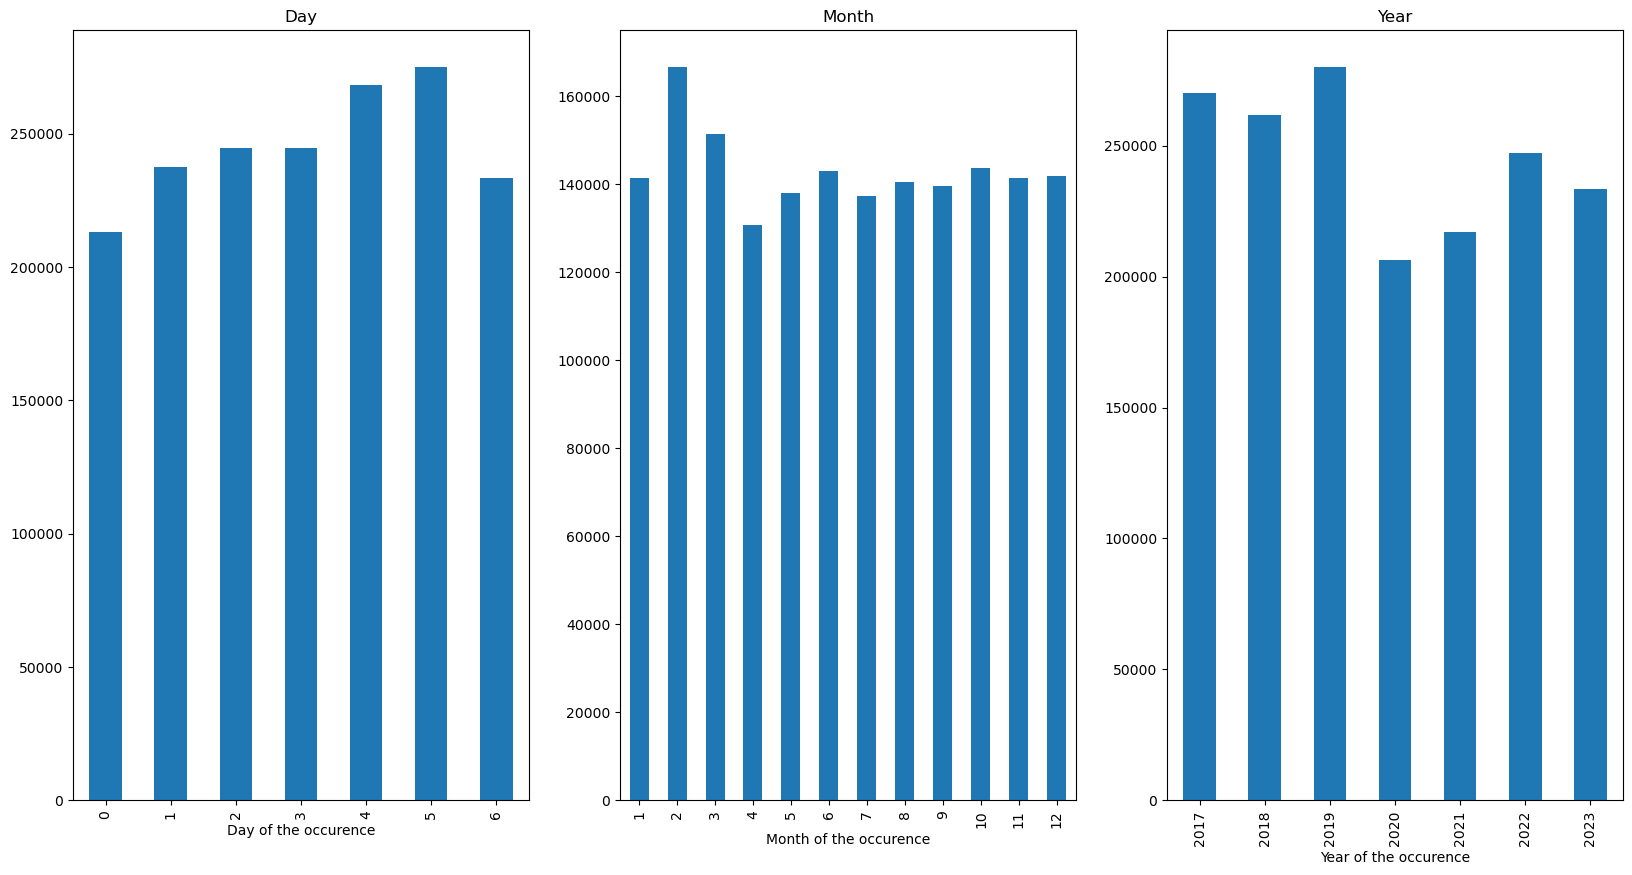

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(20,10))
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.weekday).size().plot.bar(ax=ax[0])
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.month).size().plot.bar(ax=ax[1])
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.year).size().plot.bar(ax=ax[2])
ax[0].set_title("Day")
ax[0].set_xlabel("Day of the occurence")
ax[1].set_title("Month")
ax[1].set_xlabel("Month of the occurence")
ax[2].set_title("Year")
ax[2].set_xlabel("Year of the occurence")

- From the previous graph we can conclude that during the weekends (Monday is 0 and Sunday is 6) is when most of the occurences happen, this is expected due to people going out during the night.
- In the month graph only febuary is an outlier, this can happen due to the carnival, a street party.
- We have not came back to pre covid levels of occurance but is slowly going back.

## Most dangerous neighborhoods

- As we can see from the heat map, the central neighboorhoods are the most dangerous (republica, se, bela vista), this can be due to the high amount of trafic that happen there.
- Also neighborhoods with an active nightlife (pinheiros, vila mariana, itaim bibi) tend to be more dangerous.
- There are a few neighborhoods that have poor communities near and that could help with the higher frequency of crimes.

In [9]:
import folium
import folium.plugins

In [10]:
map = folium.Map([-23.580197, -46.660212], zoom_start=15)
random_sample = stolen_cellphones_filtered[["LATITUDE", "LONGITUDE"]].dropna().sample(n=5000, random_state=42).to_numpy()
folium.plugins.HeatMap(random_sample, min_opacity=0, radius=1).add_to(map)

In [11]:
#map

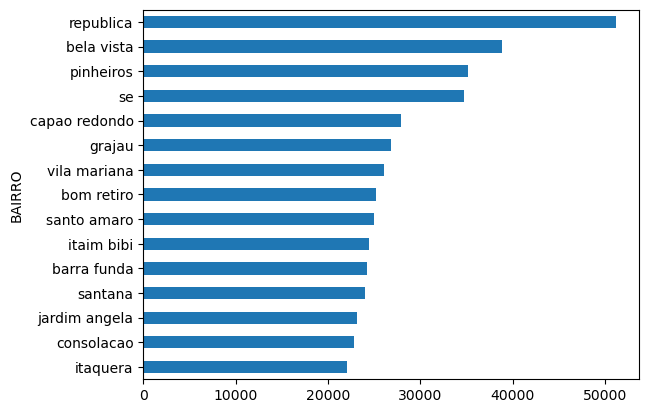

In [12]:
fig, ax = plt.subplots()
stolen_cellphones_filtered["BAIRRO"].str.lower().str.strip().value_counts().head(15).plot.barh(ax=ax)
ax.invert_yaxis()

## Neighborhood improvement

In [74]:
thefts_py = stolen_cellphones_filtered.groupby([stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.year, "BAIRRO"]).size().reset_index()
changes_crime = thefts_py.pivot_table(values=0, columns="DATA_OCORRENCIA", index="BAIRRO").dropna()
changes_crime_pct = changes_crime.pct_change(axis=1)
changes_crime_diff = changes_crime.diff(axis=1)

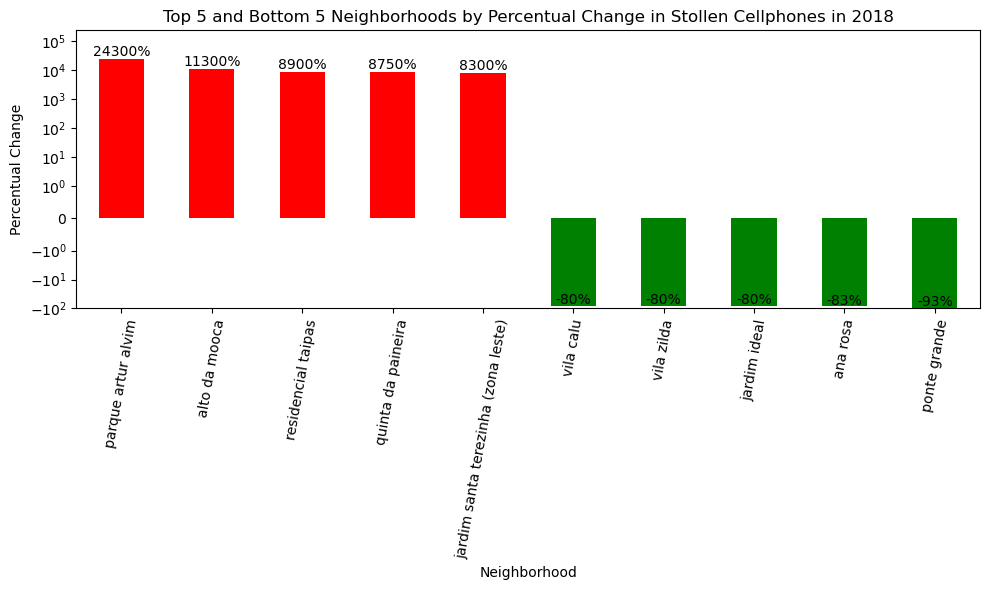

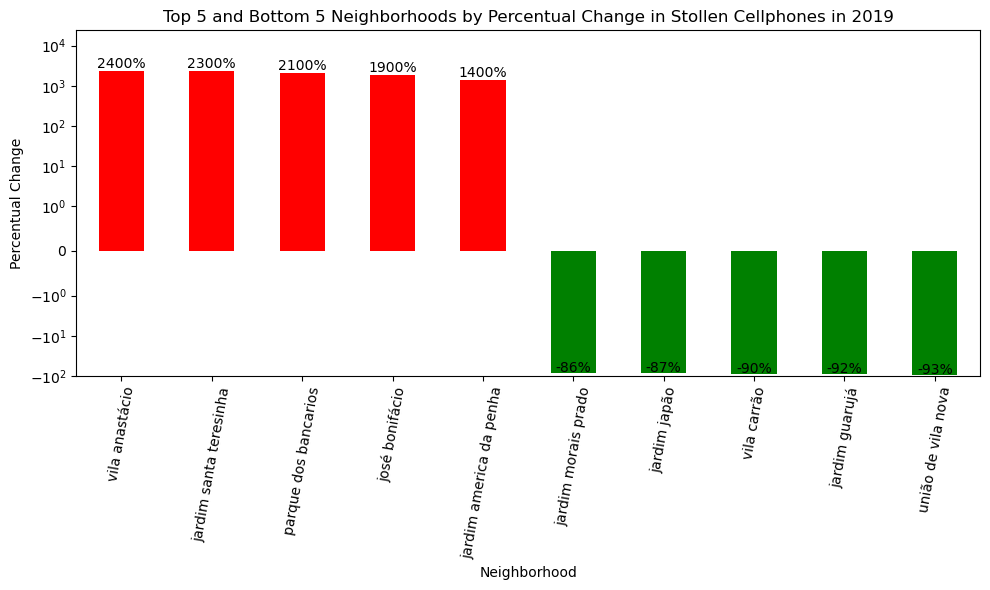

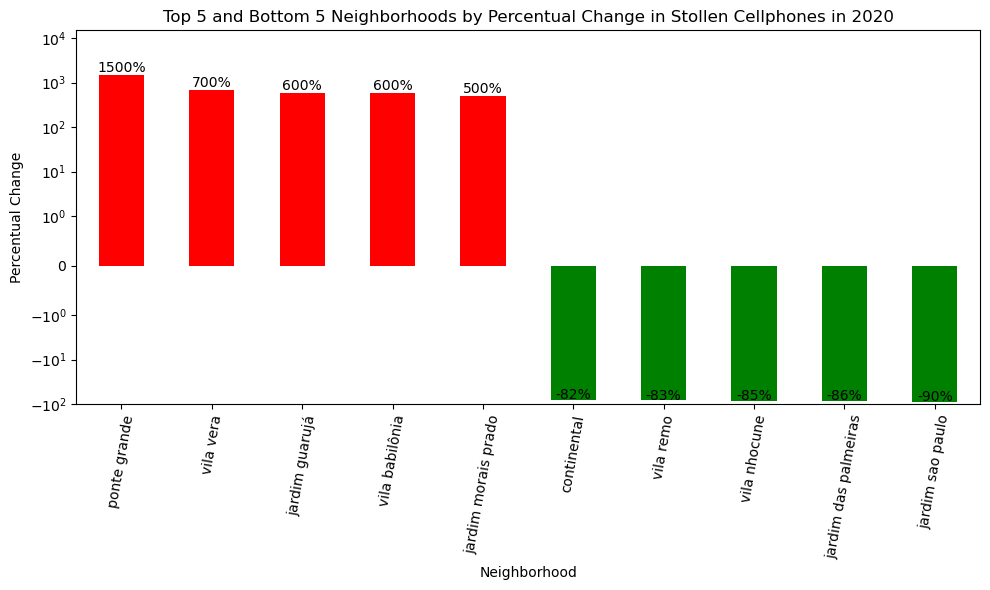

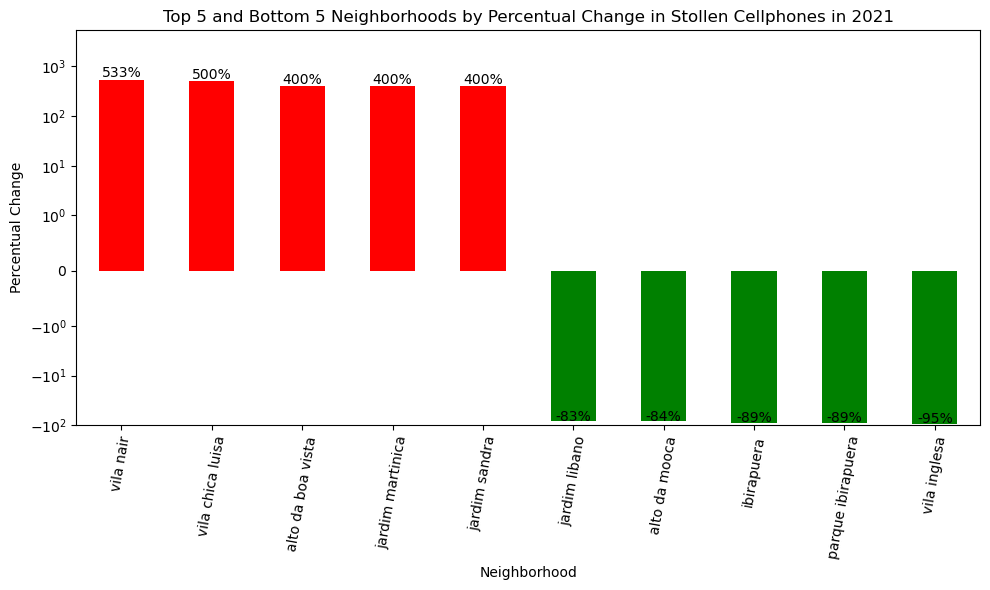

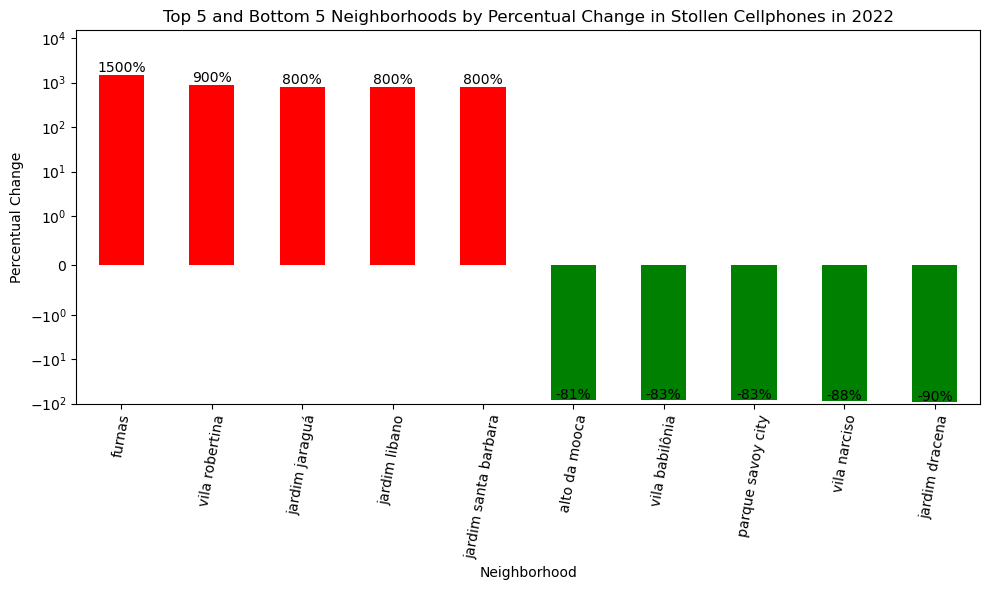

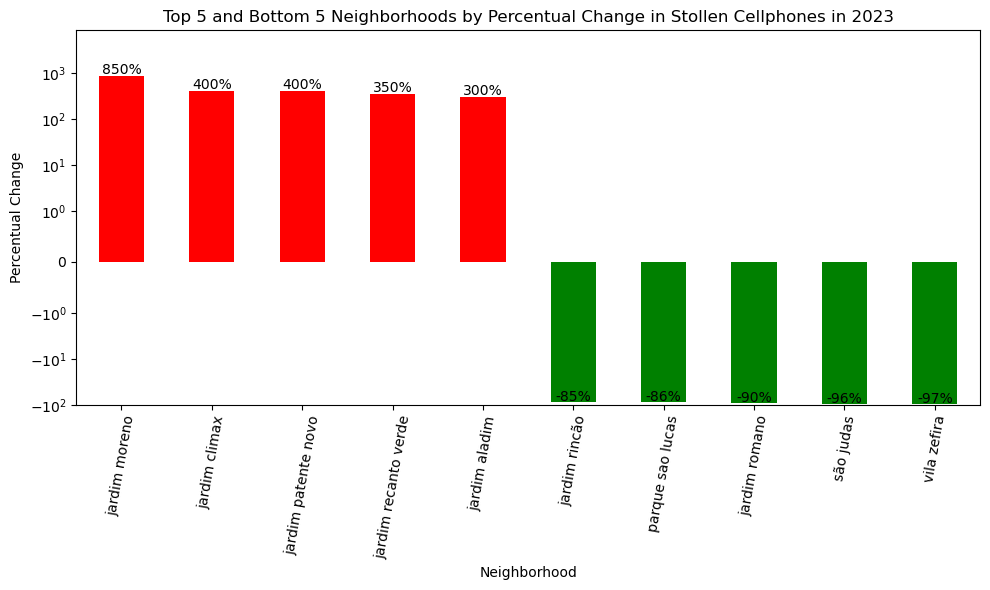

In [78]:
for year in range(2018, 2024, 1):
    year_crime_sorted = changes_crime_pct[year]
    top_5 = year_crime_sorted.nlargest(5)
    bottom_5 = year_crime_sorted.nsmallest(5).sort_values(ascending=False)
    combined = pd.concat([top_5*100, bottom_5*100])
    # Plotting
    plt.figure(figsize=(10, 6))
    bars = combined.plot(kind='bar', color=['red' if x > 0 else 'green' for x in combined])
    plt.title(f'Top 5 and Bottom 5 Neighborhoods by Percentual Change in Stollen Cellphones in {year}')
    plt.yscale('symlog', linthresh=1)
    plt.ylim(-100, combined.max() * 10)
    plt.xlabel('Neighborhood')
    plt.ylabel('Percentual Change')
    plt.xticks(rotation=80)
    for bar in bars.patches:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height-10, f'{height:.0f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


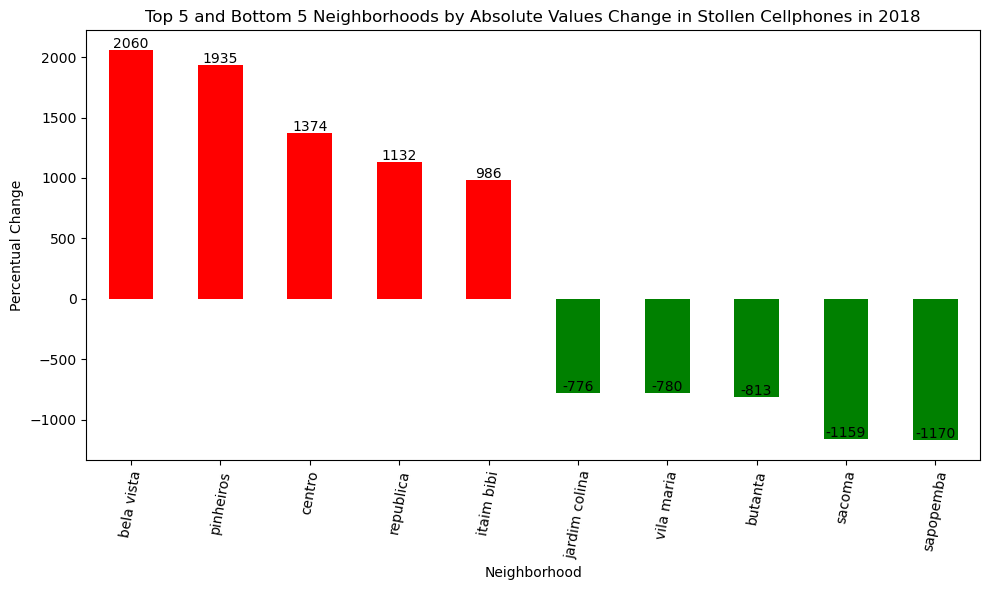

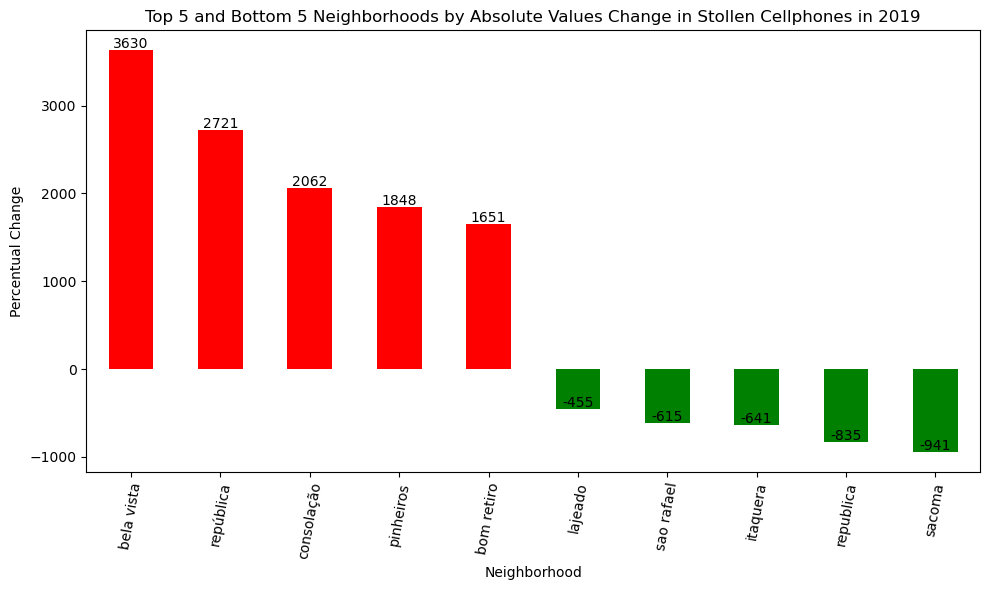

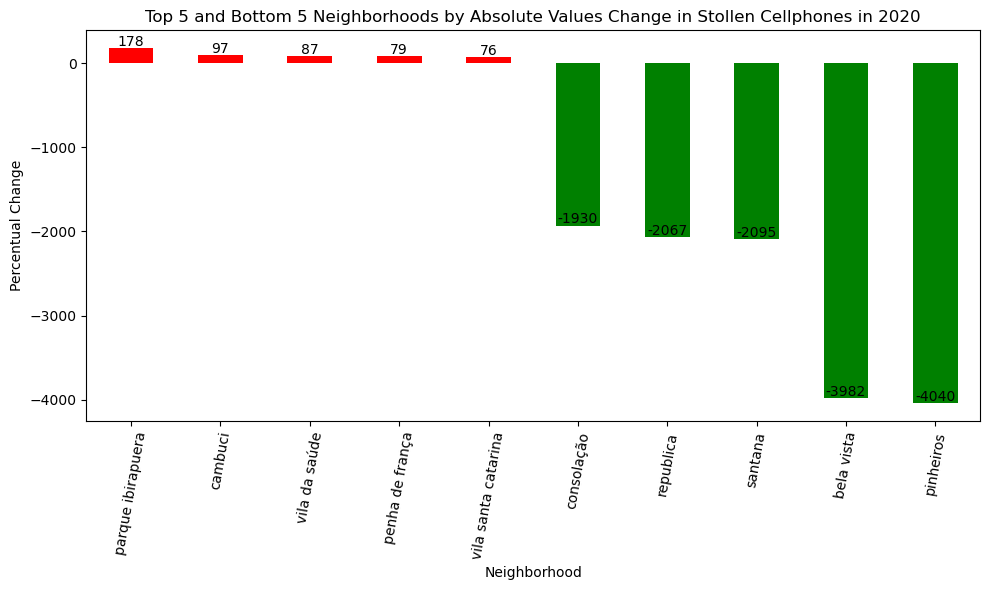

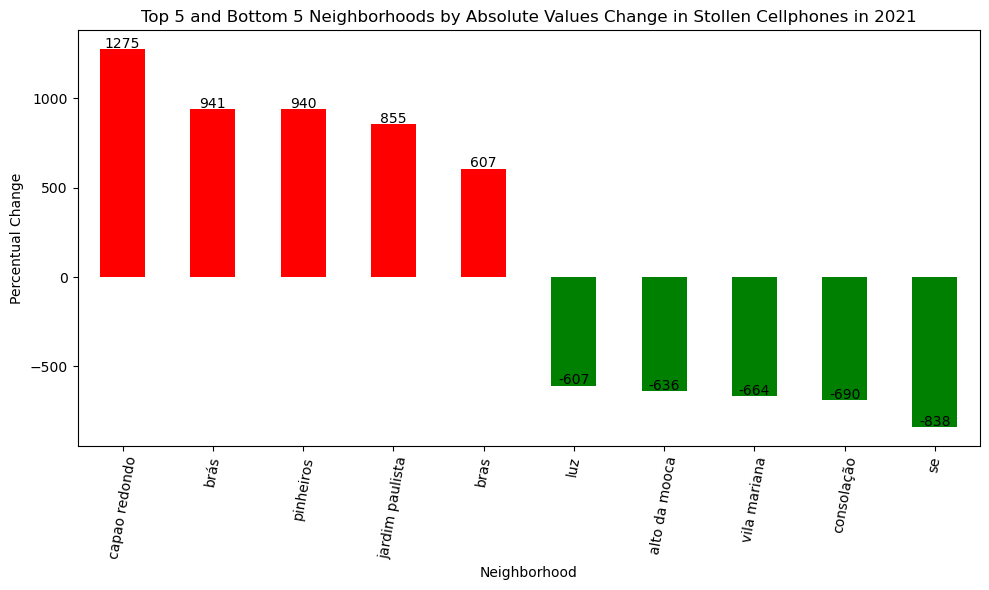

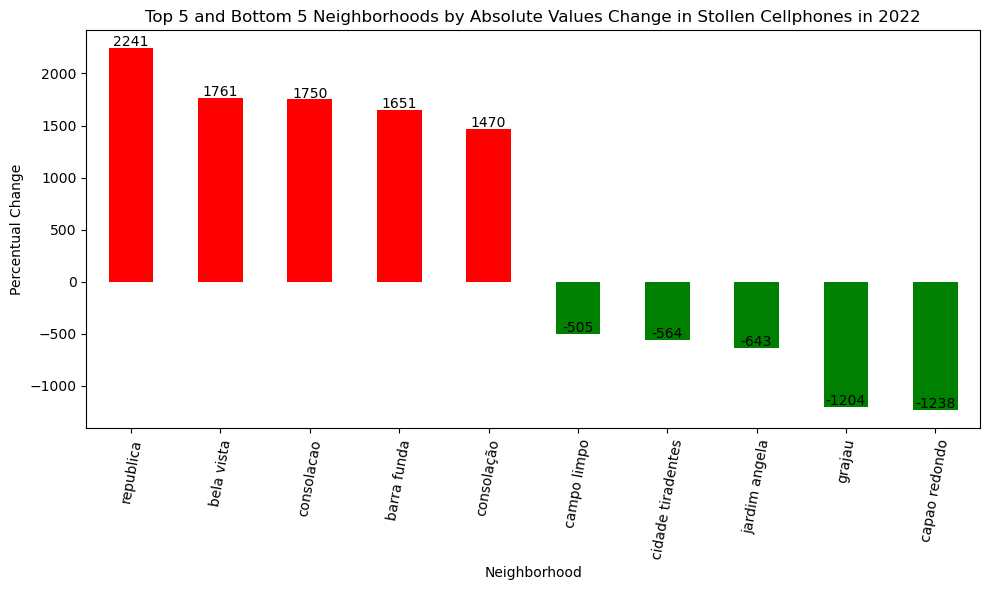

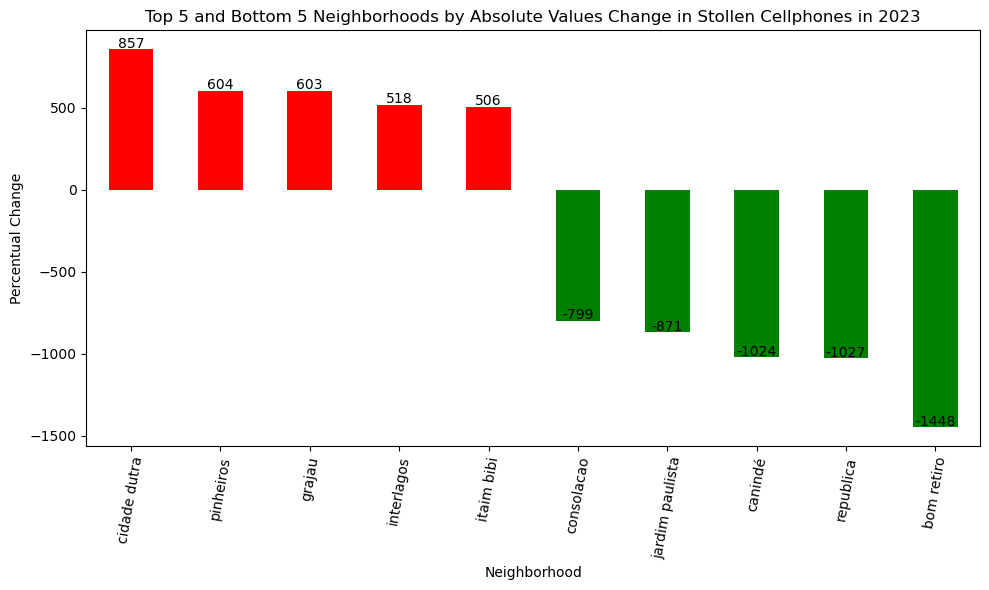

In [79]:
for year in range(2018, 2024, 1):
    year_crime_sorted = changes_crime_diff[year]
    top_5 = year_crime_sorted.nlargest(5)
    bottom_5 = year_crime_sorted.nsmallest(5).sort_values(ascending=False)
    combined = pd.concat([top_5, bottom_5])
    # Plotting
    plt.figure(figsize=(10, 6))
    bars = combined.plot(kind='bar', color=['red' if x > 0 else 'green' for x in combined])
    plt.title(f'Top 5 and Bottom 5 Neighborhoods by Absolute Values Change in Stollen Cellphones in {year}')
    #plt.yscale('symlog', linthresh=1)
    #plt.ylim(-100, combined.max() * 10)
    plt.xlabel('Neighborhood')
    plt.ylabel('Percentual Change')
    plt.xticks(rotation=80)
    for bar in bars.patches:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height-10, f'{height:.0f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

We can see a few interesting changes.
- During the COVID-19 Pandemic the most benefited, by absolute values, neighboorhoods were the most dangerous ones, specially pinheiros, due to it having an active nightlife that was cancelled that year.
- After the COVID-19 Pandemic, there was an kickback in those same neighborhoods, showing that what is likely driving the amount of occurences are the influx of people in those neighborhoods.
- It seems that there is a good policy taking place in Alto da Mooca, as it figures 2 times in the percentual reduction in the neighboorhoods.

## Most common brand of stollen cellphone
it seems to be simillar to the most sold, so it seems that the robber dosen't have a tendence to a specific brand.
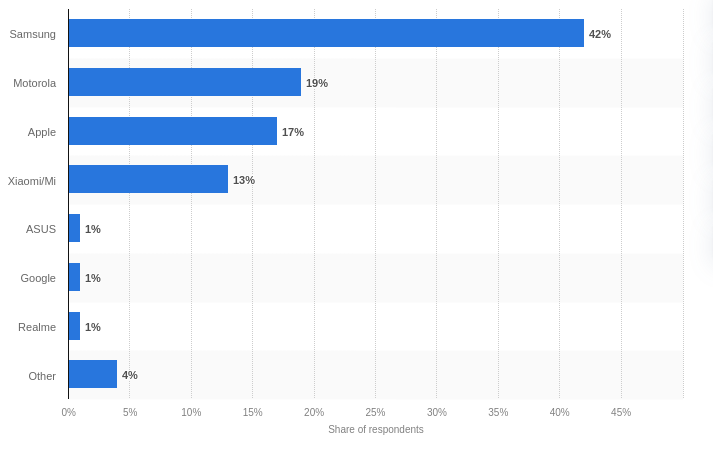

<Axes: ylabel='MARCA_OBJETO'>

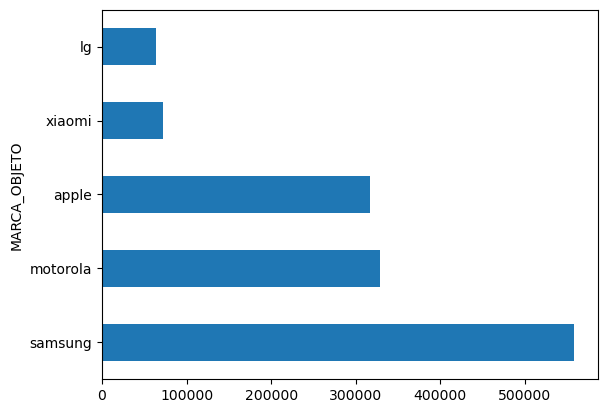

In [13]:
stolen_cellphones_filtered["MARCA_OBJETO"].str.lower().str.strip().value_counts().head().plot.barh()

# Exploring three cases (Alto da Mooca, bela vista and republica)

I choose those three neighborhoods due to them having specific caracteristics, one always reducing it's crime rate, one that always goes up and one that dosen't seems to change.

## Grouping the neighboorhoods

Using information about frequency

In [92]:
data_neighbor = stolen_cellphones_filtered[["BAIRRO", "DATA_OCORRENCIA"]]

In [94]:
data_neighbor["MONTH"] = data_neighbor["DATA_OCORRENCIA"].dt.month
data_neighbor["YEAR"] = data_neighbor["DATA_OCORRENCIA"].dt.year

/tmp/ipykernel_96828/1575071244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neighbor["MONTH"] = data_neighbor["DATA_OCORRENCIA"].dt.month
/tmp/ipykernel_96828/1575071244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neighbor["YEAR"] = data_neighbor["DATA_OCORRENCIA"].dt.year


In [99]:
month_agg = data_neighbor.groupby(["BAIRRO","MONTH"]).size().reset_index()
year_agg = data_neighbor.groupby(["BAIRRO","YEAR"]).size().reset_index()

In [110]:
#month_agg.pivot_table(columns="MONTH", index="BAIRRO", values=0)
year_df = year_agg.pivot_table(columns="YEAR", index="BAIRRO", values=0).dropna()
df_frequencies = year_df.join(month_agg.pivot_table(columns="MONTH", index="BAIRRO", values=0).loc[year_df.index]).fillna(0)

In [116]:
from sklearn.cluster import k_means

In [120]:
centroids, label, inertia = k_means(df_frequencies, n_clusters=4)

In [123]:
df_frequencies["labels"] = label

<Axes: ylabel='count'>

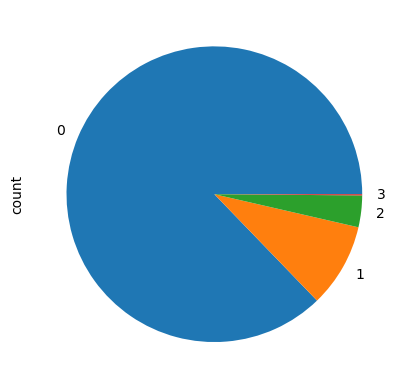

In [144]:
df_frequencies["labels"].value_counts().plot.pie()

<Axes: >

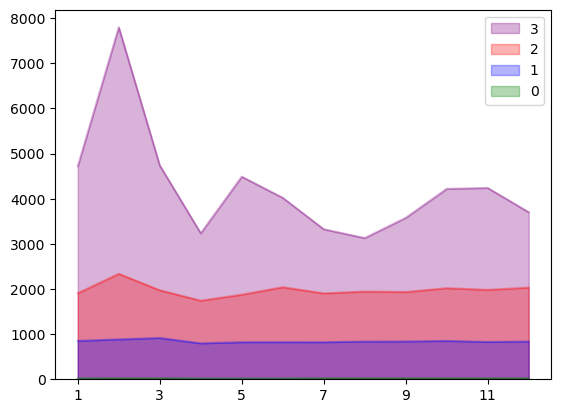

In [172]:
fig, ax = plt.subplots()
df_frequencies[df_frequencies["labels"] == 3].iloc[:, -13:-1].mean().plot.area(ax=ax, label=3, alpha=.3, color="purple", legend=True)
df_frequencies[df_frequencies["labels"] == 2].iloc[:, -13:-1].mean().plot.area(ax=ax, label=2, alpha=.3, color="red", legend=True)
df_frequencies[df_frequencies["labels"] == 1].iloc[:, -13:-1].mean().plot.area(ax=ax, label=1, alpha=.3, color="blue", legend=True)
df_frequencies[df_frequencies["labels"] == 0].iloc[:, -13:-1].mean().plot.area(ax=ax, label=0, alpha=.3, color="green", legend=True)

#df_frequencies[df_frequencies["labels"] == 1].iloc[:, :-1].mean().plot.bar(ax=ax)

In [180]:
mean_3 = df_frequencies[df_frequencies["labels"] == 3].iloc[:, -13:-1].mean()
mean_2 = df_frequencies[df_frequencies["labels"] == 2].iloc[:, -13:-1].mean()
mean_1 = df_frequencies[df_frequencies["labels"] == 1].iloc[:, -13:-1].mean()
mean_0 = df_frequencies[df_frequencies["labels"] == 0].iloc[:, -13:-1].mean()

In [197]:
mean_2.name = 2
mean_3.name = 3
mean_1.name = 1
mean_0.name = 0

In [200]:
def minmaxscaler(serie):
    return ((serie - serie.min())/(serie.max() - serie.min()))

<Axes: >

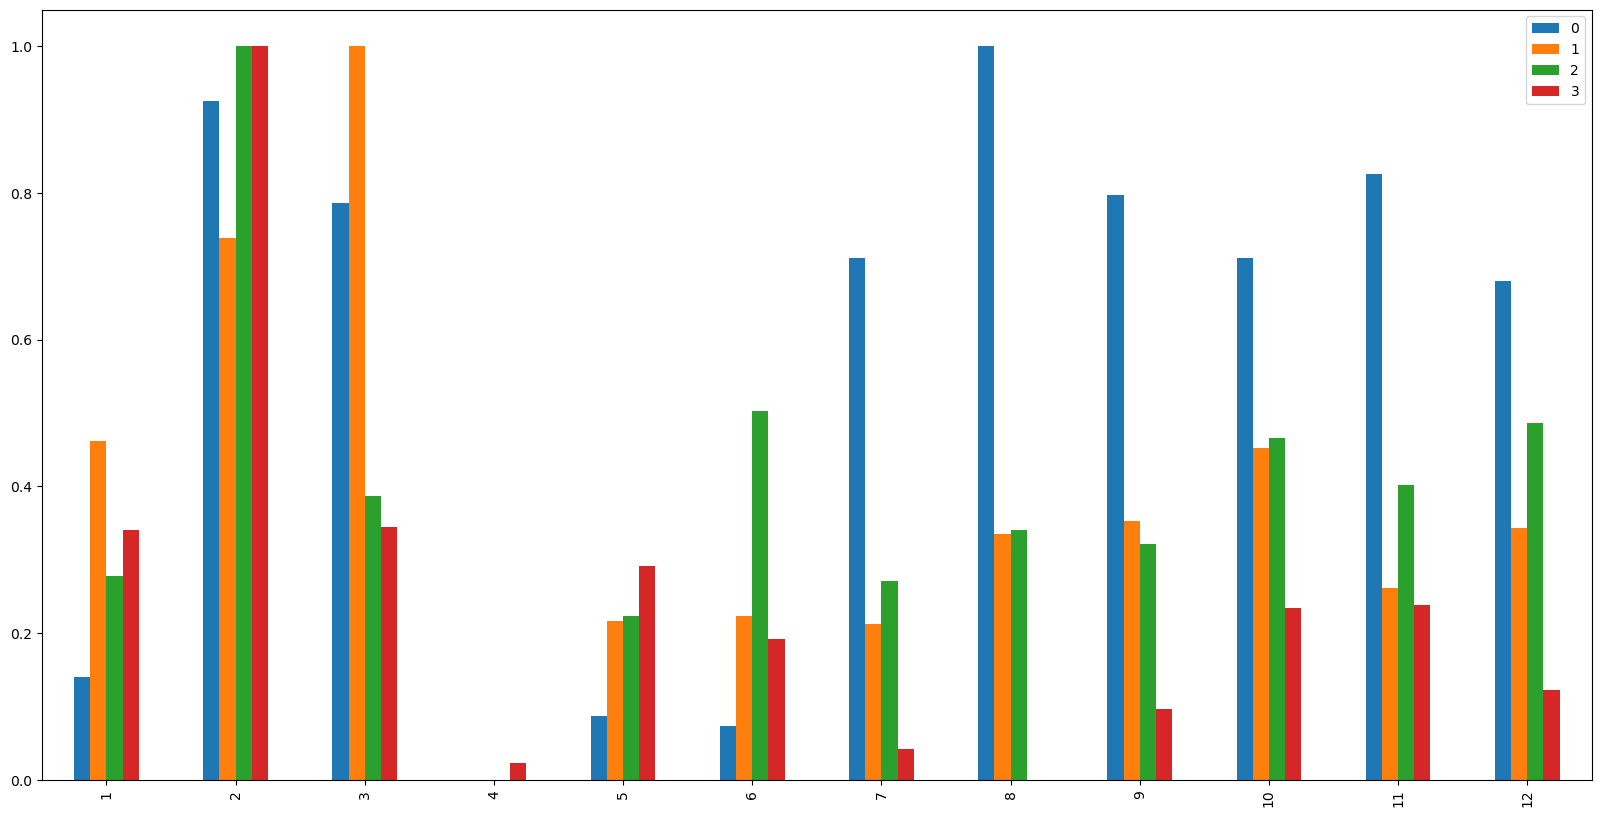

In [205]:
pd.concat([minmaxscaler(mean_0), 
           minmaxscaler(mean_1),
           minmaxscaler(mean_2),
           minmaxscaler(mean_3),], axis=1).plot.bar(figsize=(20,10))